In [1]:
%load_ext rpy2.ipython
%R library(dplyr);library(magrittr);library(ggplot2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Use suppressPackageStartupMessages to eliminate package startup messages.


In [2]:
%%R
p<-read.csv("./data/phage.genome.info.txt", header=TRUE, sep="\t")
t<-read.csv("./data/bulk_phage_trna_summary.txt",header=TRUE, sep="\t")

p$ncbi_acc<-gsub(" ","",p$ncbi_acc)
t$phage_full<-gsub(" ","", t$phage_full)


#delete rows that are from partial genomes or genes:
p<-p[!grepl("' 'gene|partial|protein",p$name),]
t<-t[!grepl("' 'gene|partial|protein",t$phage_short),]

t$phage_short%>%unique%>%length%>%print
p$ncbi_acc%>%unique%>%length%>%print

t%>%group_by(phage_full)%>%summarise(trna_count=n())->txp_sum
p$trna_count<-txp_sum$trna_count[match(p$ncbi_acc, txp_sum$phage_full)]
p[is.na(p)]<-0


[1] 985
[1] 3079


In [3]:
%%R
head(p)

trna_binary=vector()
trna_bin=vector()

for (i in p$trna_count){
    if (i>0){
        trna_binary<-c(trna_binary, 1)
    } else {trna_binary<-c(trna_binary, 0)}}
for (i in p$trna_count){
    if (i>=20){
        trna_bin<-c(trna_bin, "high")
    } else if (5<i & i<20) {
        trna_bin<-c(trna_bin, "med")
    } else if (i<=5 & i>1) {
        trna_bin<-c(trna_bin, "low")
    } else if (i==1){
        trna_bin<-c(trna_bin, "one")
    }
    else {
        trna_bin<-c(trna_bin, "none")
    }}

p<-cbind.data.frame(p, trna_binary, trna_bin)    
head(p)

     ncbi_acc                               name        tax   size       gc
1  KF582788.2     Escherichia phage vB_EcoM_JS09 Myoviridae 169148 37.64928
2  HQ630627.1           Pseudomonas phage PhiPA3 Myoviridae 309208 47.72548
3 NC_024794.1  Escherichia phage vB_EcoM_PhAPEC2 Myoviridae 167318 37.72517
4  JX080304.2          Staphylococcus phage MSA6 Myoviridae 148243 30.24291
5  JX080305.2           Staphylococcus phage P4W Myoviridae 147590 30.39163
6  JX080303.2        Staphylococcus phage Fi200W Myoviridae 148481 30.39311
  trna_count trna_binary trna_bin
1          2           1      low
2          4           1      low
3          3           1      low
4          4           1      low
5          4           1      low
6          4           1      low


In [4]:
%%R
caudos<-p[grepl("Myoviridae|Podoviridae|Siphoviridae",p$tax),]

host<-vector()

for (i in caudos$name){
    m<-strsplit(i, " ")
    host<-c(host, (unlist(m)[2]))
    }
host<-gsub("Mycobacteriophage","Mycobacterium", host)
host<-gsub("Cyanophage","Synechococcus", host)
host<-gsub("Vibriophage","Vibrio", host)
host<-gsub("Lactoccoccus","Lactococcus",host)
#host<-gsub("Bacteriophage","Escherechia", host)
host<-gsub("Enterobacterial|Enterobacteriophage|Enterobacteriaphage","Enterobacteria", host)
host<-gsub("Iodobacteriophage","Iodobacter", host)
caudos<-cbind.data.frame(caudos, host)
caudos%>%group_by(host)%>%summarise(phage_count=n())%>%.[order(-.$phage_count),]->hp_count
#print(hp_count$host[order(hp_count$host)])
print(hp_count)

Source: local data frame [136 x 2]

                host phage_count
1      Mycobacterium         499
2      Synechococcus         183
3     Enterobacteria         156
4        Pseudomonas         154
5     Staphylococcus         141
6      Bacteriophage         122
7           Bacillus          94
8             Vibrio          79
9         Salmonella          78
10 Propionibacterium          77
..               ...         ...


In [5]:
%%R
caudos$ncbi_acc%>%unique%>%length%>%print
caudos[!caudos$trna_count==0,]%>%nrow%>%print

[1] 2518
[1] 949


In [6]:
%%R
top_hosts<-hp_count[hp_count$phage_count>30&hp_count$host!="Bacteriophage",]
top_host_info<-merge(top_hosts, caudos, by="host")

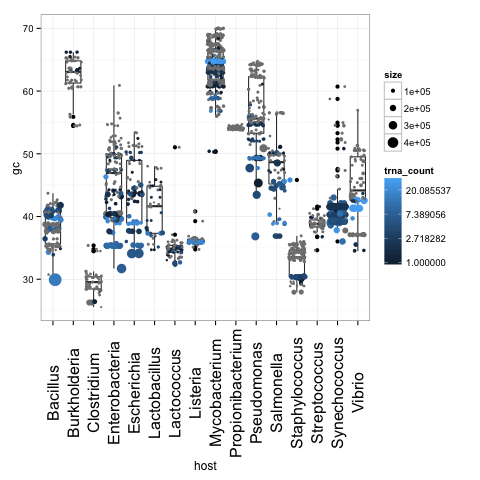

In [7]:
%%R
th<-ggplot(top_host_info, aes(host, gc))+geom_boxplot()+geom_jitter(aes(color=trna_count, size=size))+theme_bw()
th<-th+scale_colour_gradient(trans = "log")+theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=16))
plot(th)

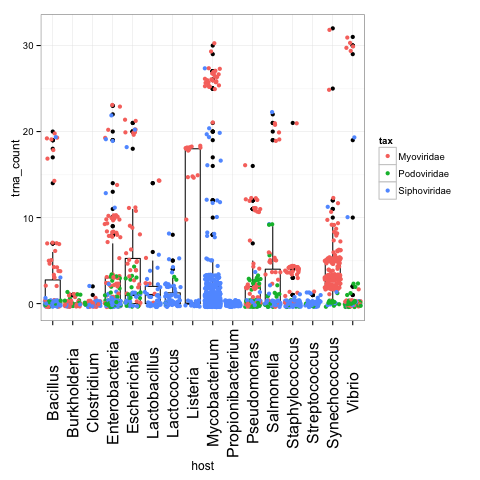

In [8]:
%%R
th<-ggplot(top_host_info, aes(host, trna_count))+geom_boxplot(color="grey3")+geom_jitter(aes(color=tax))+theme_bw()
th<-th+theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=16))
plot(th)
write.table(top_host_info, "./data/top_host_phage_info.txt", sep="\t", col.names=FALSE, row.names=FALSE, quote=FALSE)

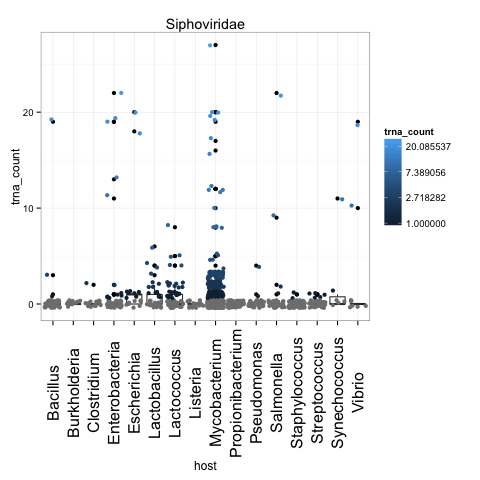

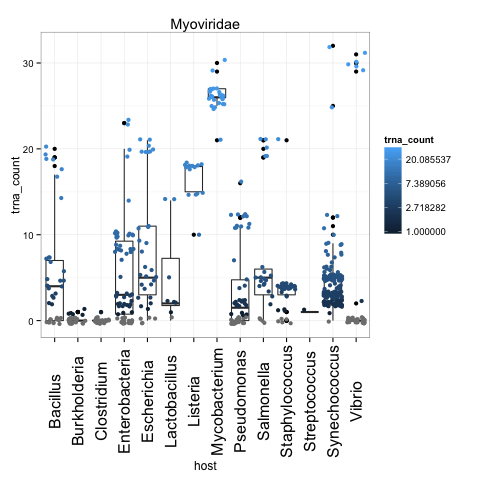

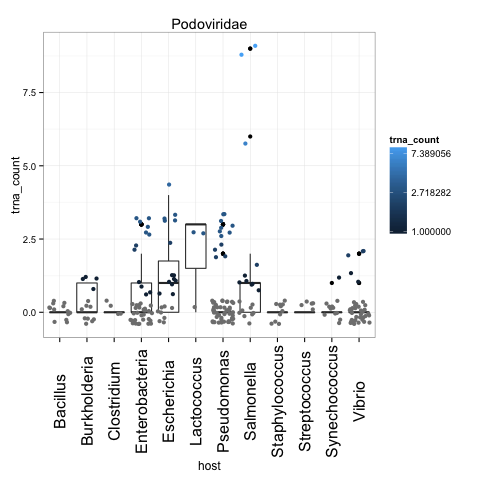

In [9]:
%%R
for (t in top_host_info$tax%>%unique){
th<-ggplot(top_host_info[top_host_info$tax==t,], aes(host, trna_count))+geom_boxplot()+geom_jitter(aes(color=trna_count))+theme_bw()
th<-th+scale_colour_gradient(trans = "log")+theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=16))+labs(title=t)
plot(th)
    }

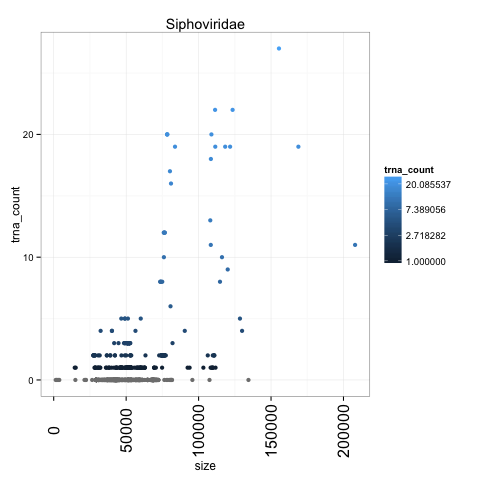

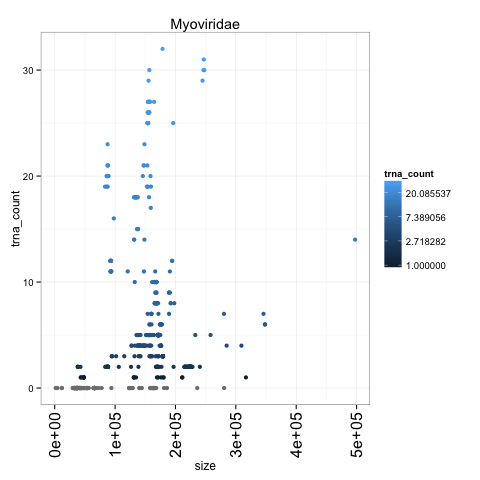

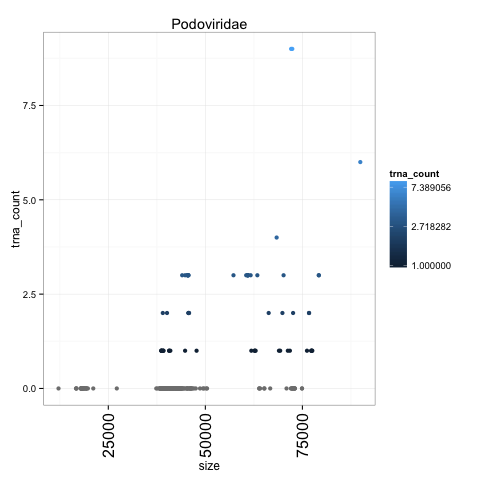

In [109]:
%%R
for (t in top_host_info$tax%>%unique){
th<-ggplot(top_host_info[top_host_info$tax==t,], aes(size, trna_count))+geom_point(aes(color=trna_count))+theme_bw()
th<-th+scale_colour_gradient(trans = "log")+theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=16))+labs(title=t)
plot(th)
    }

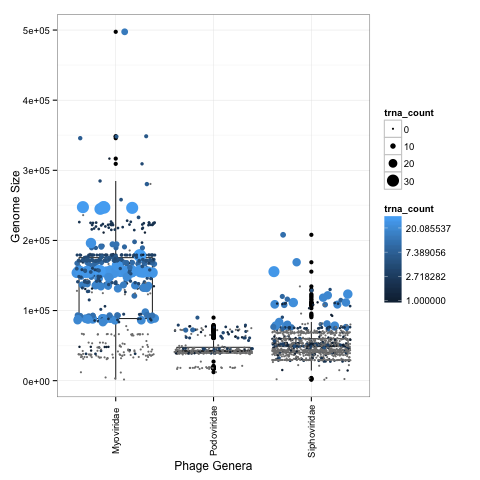

In [121]:
%%R
th<-ggplot(top_host_info, aes(tax, size))+geom_boxplot()+geom_jitter(aes(color=trna_count, size=trna_count))+theme_bw()
th<-th+scale_colour_gradient(trans = "log")+theme(axis.text.x  = element_text(angle=90, vjust=0.5))+labs(x="Phage Genera", y="Genome Size")
plot(th)


	Welch Two Sample t-test

data:  caudos$size[which(caudos$trna_binary == "1")] and caudos$size[which(caudos$trna_binary == "0")]
t = 31.4203, df = 1134.904, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 65251.06 73943.11
sample estimates:
mean of x mean of y 
119148.53  49551.45 



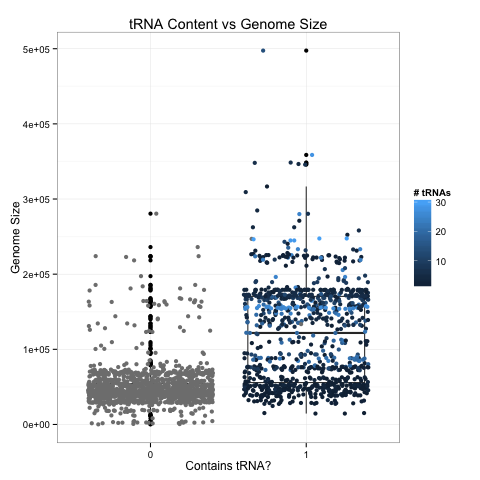

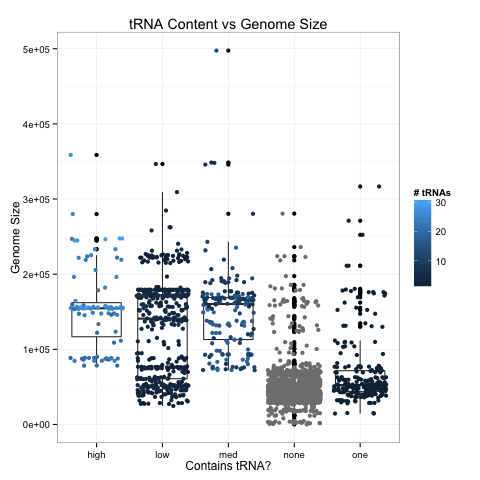

In [40]:
%%R
th1<-ggplot(caudos, aes(as.factor(trna_binary), size))+geom_boxplot()+geom_jitter(aes(color=trna_count))+theme_bw()
th1<-th1+scale_colour_gradient(limits=c(1,30))+labs(y="Genome Size", x="Contains tRNA?", title="tRNA Content vs Genome Size", color="# tRNAs", size="# tRNAs")
plot(th1)

th2<-ggplot(caudos, aes(as.factor(trna_bin), size))+geom_boxplot()+geom_jitter(aes(color=trna_count))+theme_bw()
th2<-th2+scale_colour_gradient(limits=c(1,30))+labs(y="Genome Size", x="Contains tRNA?", title="tRNA Content vs Genome Size", color="# tRNAs", size="# tRNAs")
plot(th2)

t.test(caudos$size[which(caudos$trna_binary=="1")], caudos$size[which(caudos$trna_binary=="0")])

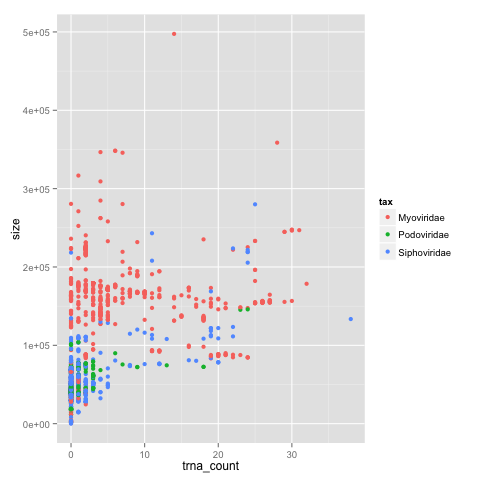

In [29]:
%%R
svtr<-ggplot(caudos, aes(trna_count, size))+geom_point(aes(color=tax))
plot(svtr)

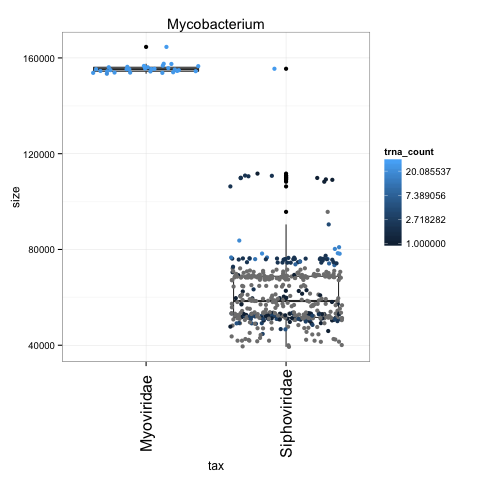

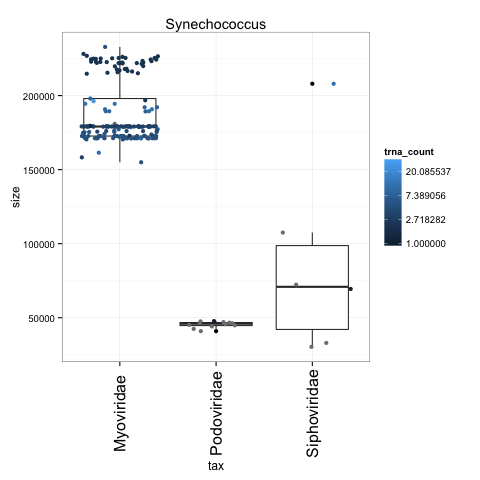

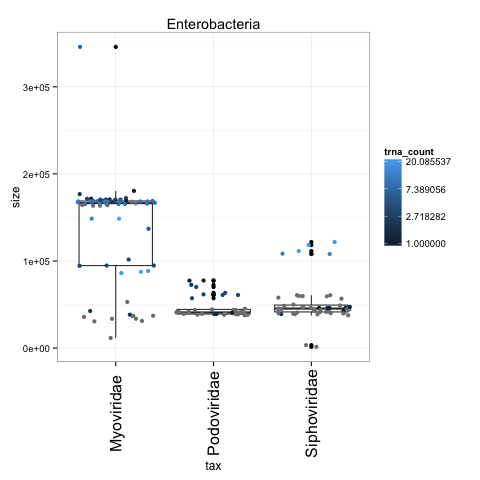

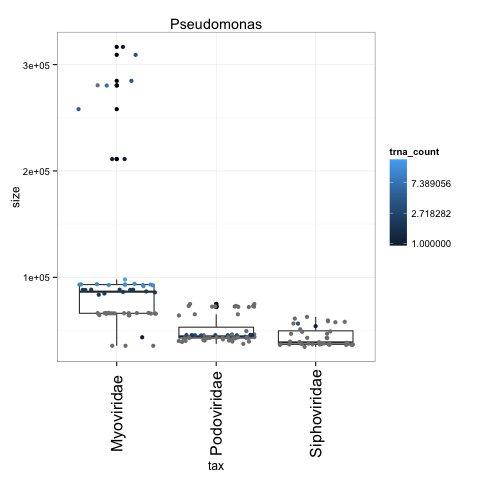

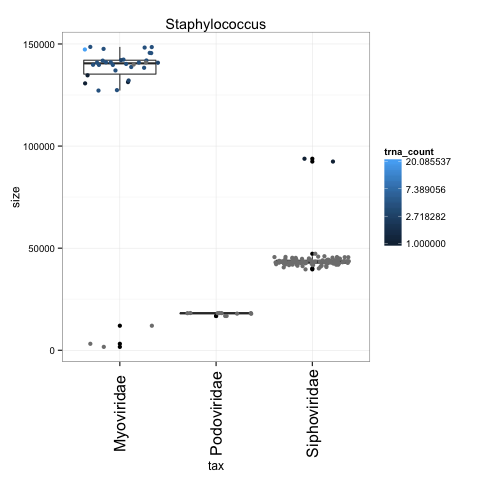

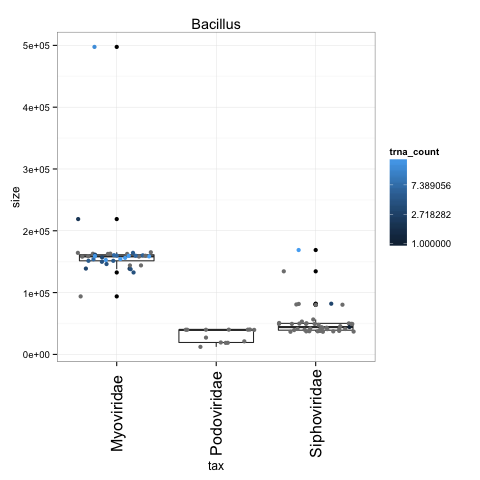

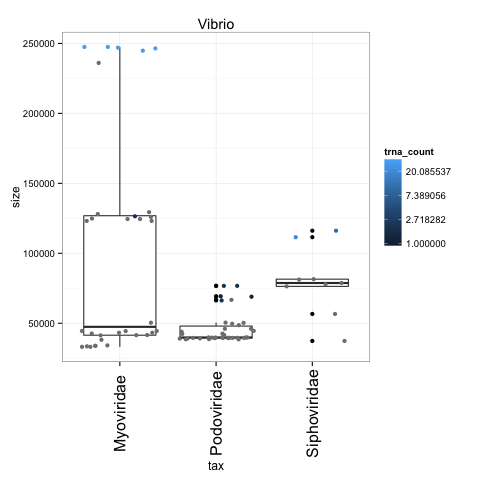

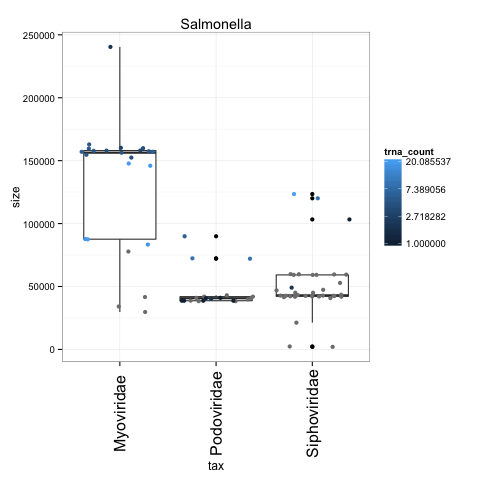

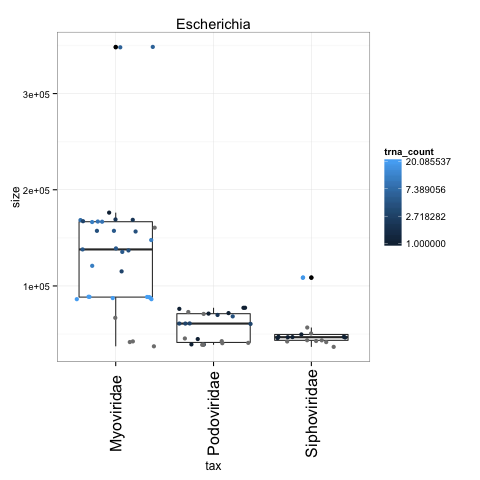

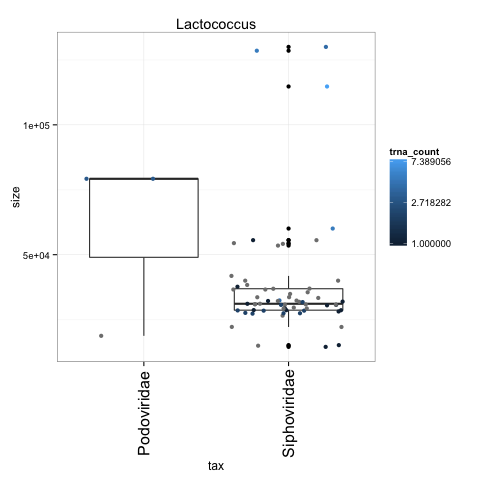

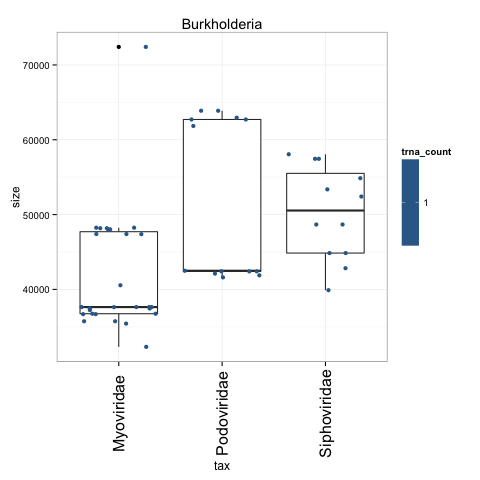

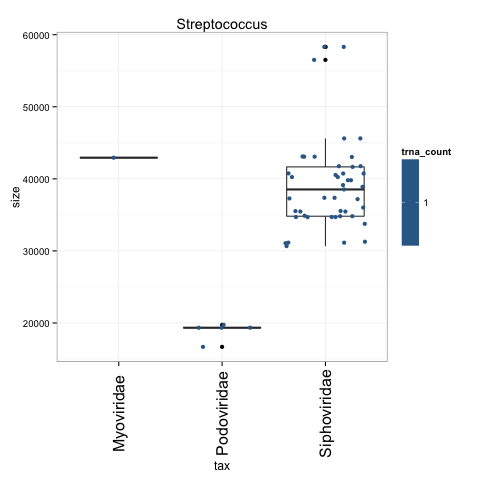

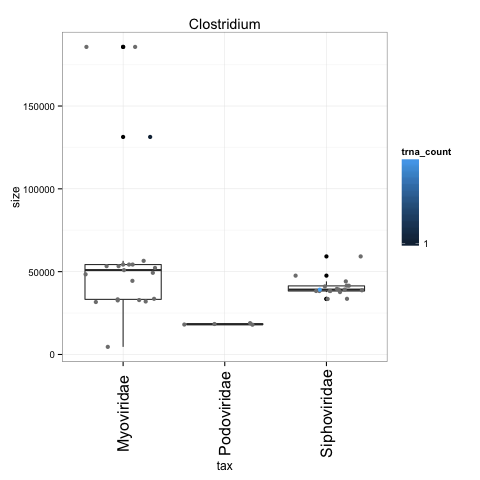

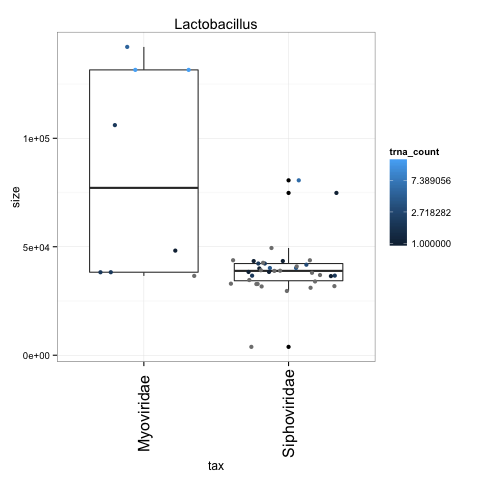

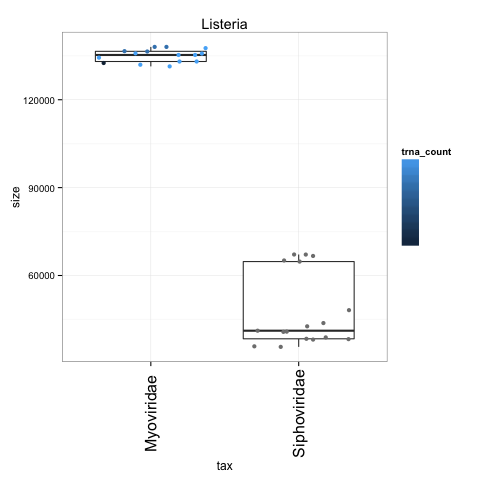

In [30]:
%%R
for (h in top_hosts$host[top_hosts$host!="Propionibacterium"]){
th<-ggplot(top_host_info[top_host_info$host==h,], aes(tax, size))+geom_boxplot()+geom_jitter(aes(color=trna_count))+theme_bw()
th<-th+theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=16))+labs(title=h)+scale_colour_gradient(trans = "log")
plot(th)
    
    }

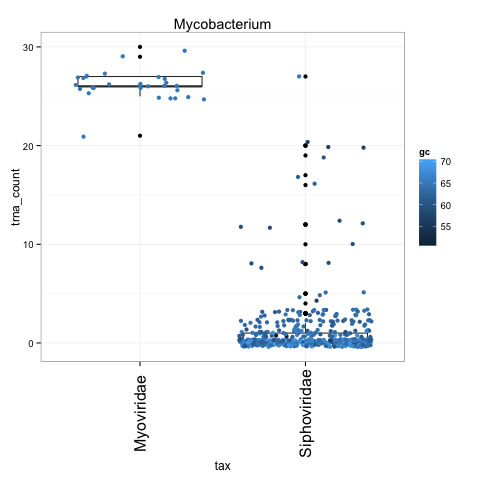

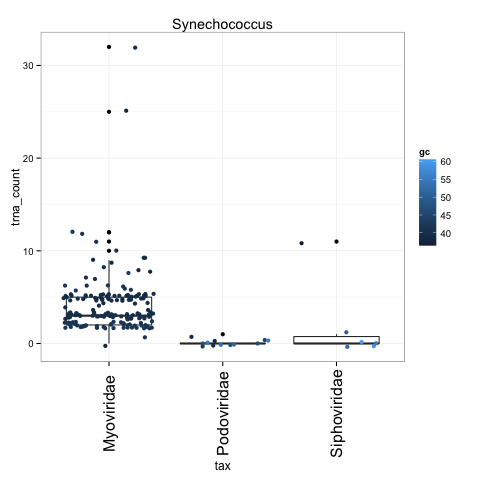

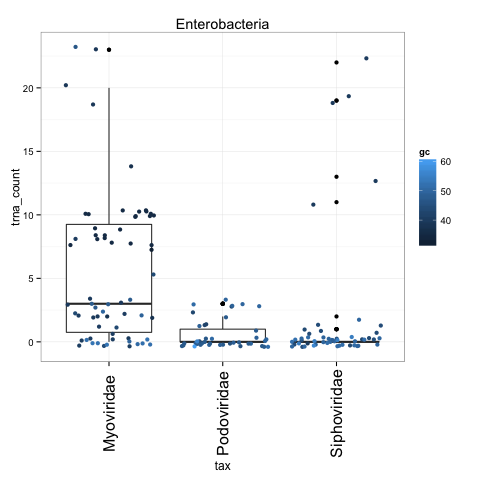

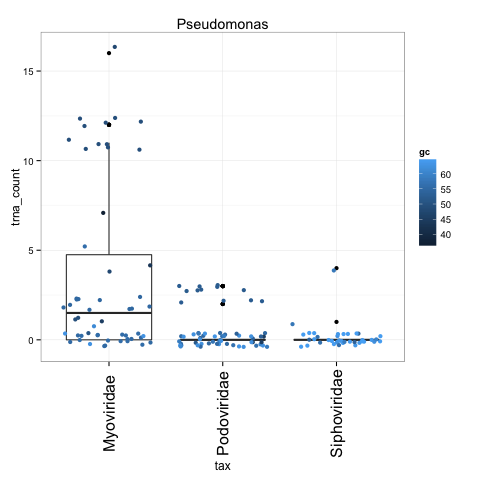

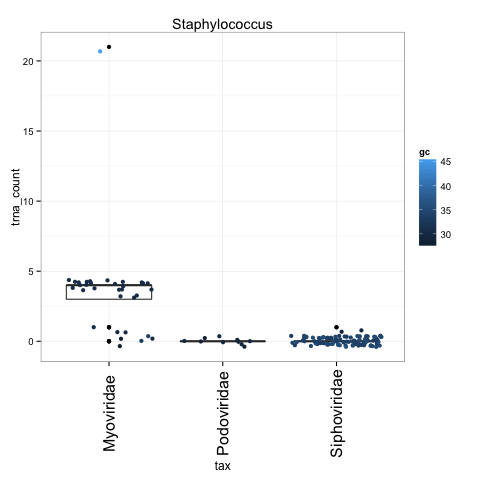

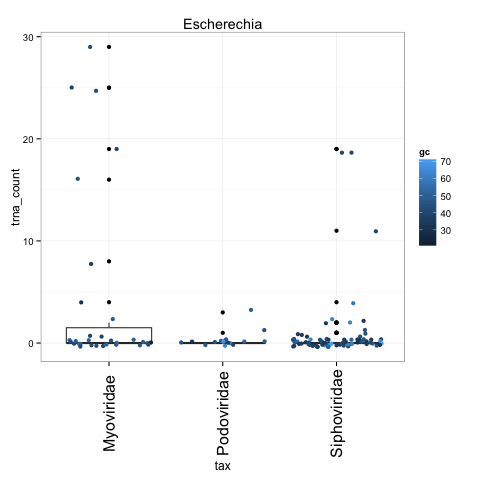

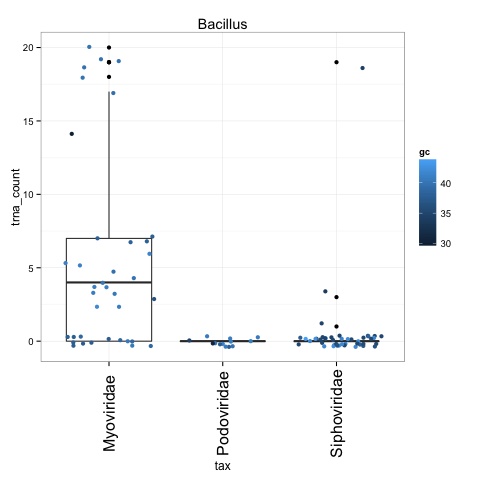

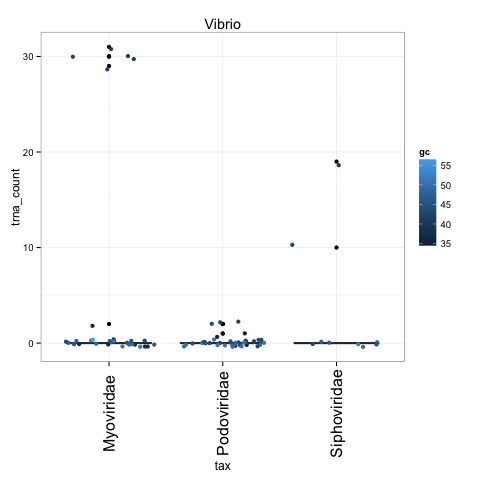

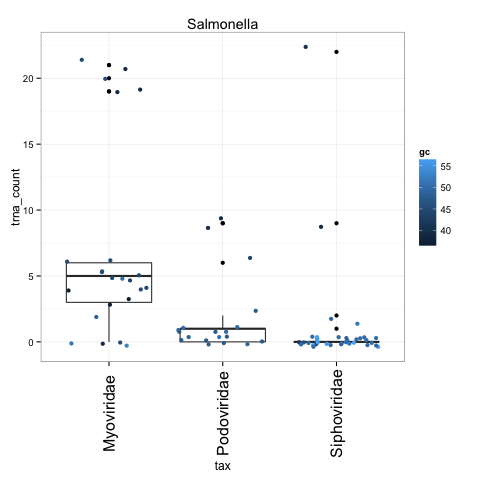

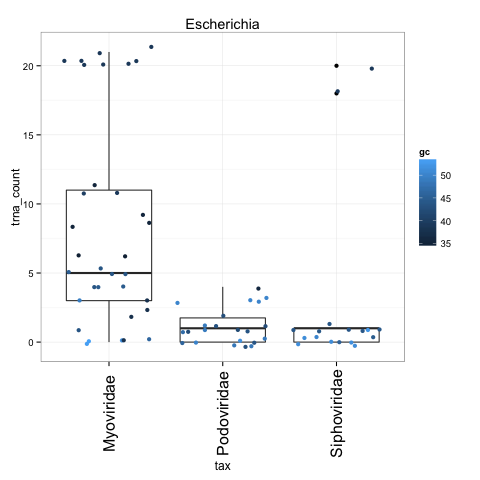

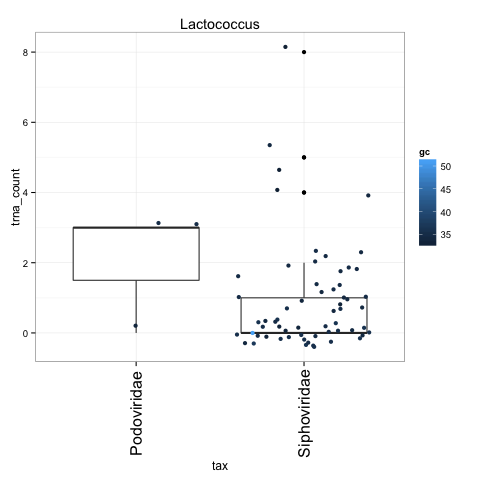

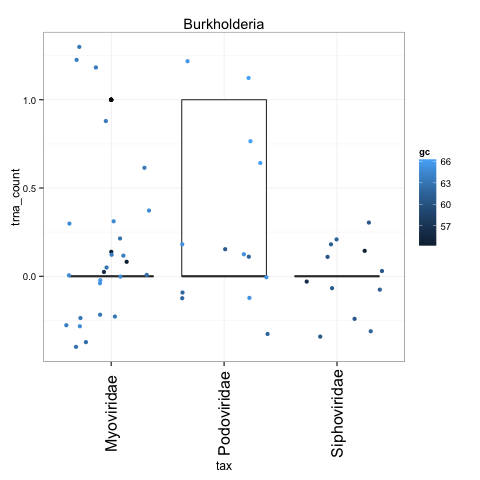

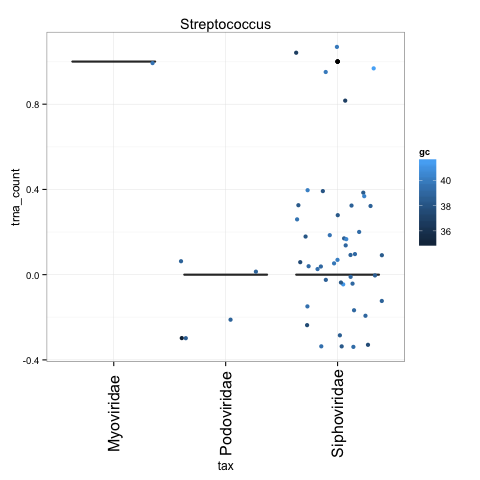

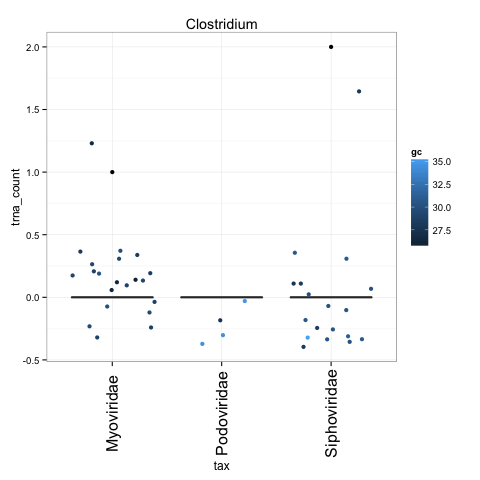

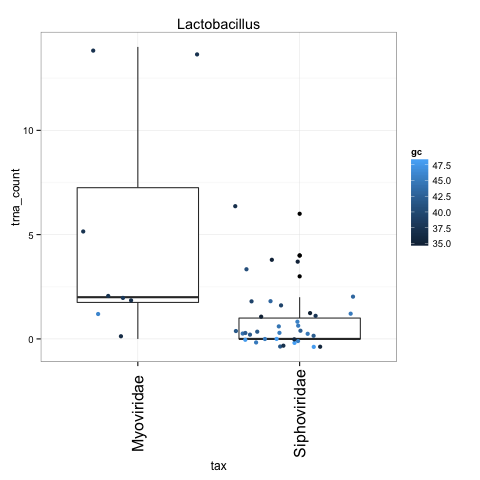

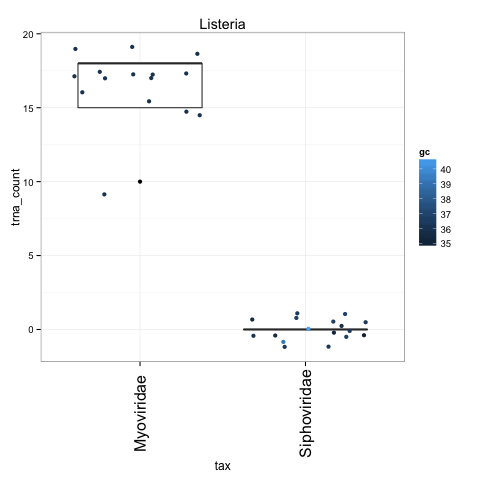

In [135]:
%%R
for (h in top_hosts$host[top_hosts$host!="Propionibacterium"]){
th<-ggplot(top_host_info[top_host_info$host==h,], aes(tax, trna_count))+geom_boxplot()+geom_jitter(aes(color=gc))+theme_bw()
th<-th+theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=16))+labs(title=h)
plot(th)
    
    }

In [31]:
%%R
thi<-top_host_info
thi%>%group_by(host)%>%summarise(mean_gc=mean(gc))->thi_gc


thi$mean_gc<-thi_gc$mean_gc[match(thi$host, thi_gc$host)]
thi<-mutate(thi,gc_dif=gc-mean_gc)

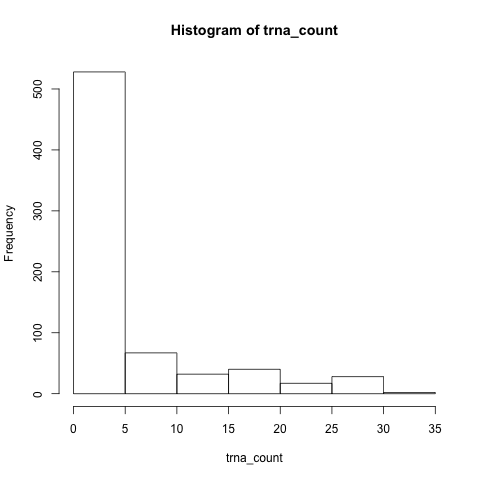

In [32]:
%%R
with(thi[thi$trna_count>0,], hist(trna_count, breaks=max(trna_count)/5))


	Welch Two Sample t-test

data:  thi$gc_dif[which(thi$trna_binary == "1")] and thi$gc_dif[which(thi$trna_binary == "0")]
t = -16.9606, df = 1563.303, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -3.174280 -2.516183
sample estimates:
mean of x mean of y 
-1.727797  1.117434 



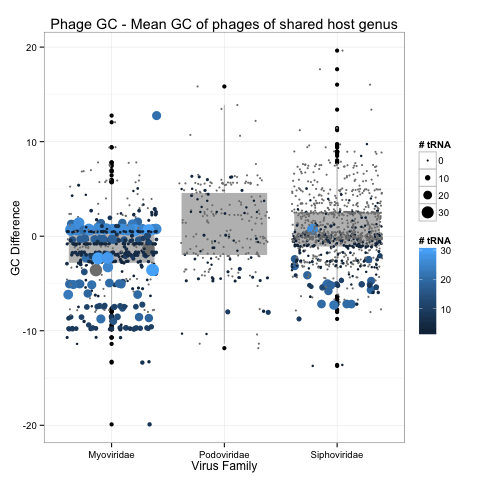

In [36]:
%%R
c2<-ggplot(thi, aes(tax, gc_dif))+geom_boxplot(color="grey", fill="grey", point="grey")+geom_jitter(aes(color=(trna_count), size=trna_count))+theme_bw()
c2<-c2+scale_colour_gradient(limits=c(1,30))+labs(title="Phage GC - Mean GC of phages of shared host genus", y="GC Difference", x="Virus Family", color="# tRNA", size="# tRNA")
plot(c2) 

t.test(thi$gc_dif[which(thi$trna_binary=="1")], thi$gc_dif[which(thi$trna_binary=="0")])

Scale for 'colour' is already present. Adding another scale for 'colour', which will replace the existing scale.


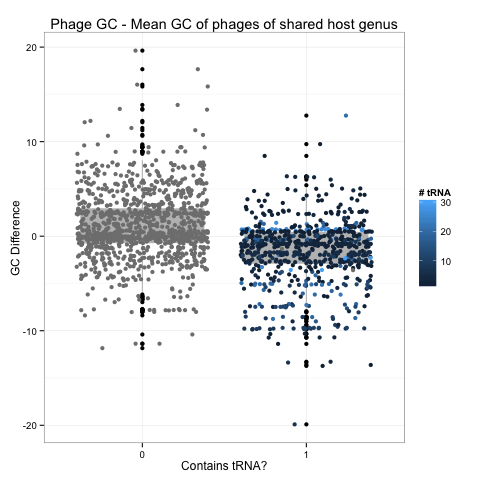

In [39]:
%%R
c3<-ggplot(thi, aes(as.factor(trna_binary), gc_dif))+geom_boxplot(color="grey", fill="grey", point="grey")+geom_jitter(aes(color=(trna_count)))+theme_bw()
c3<-c3+scale_colour_gradient(limits=c(1,30))+scale_colour_gradient(limits=c(1,30))+labs(title="Phage GC - Mean GC of phages of shared host genus", y="GC Difference", x="Contains tRNA?", color="# tRNA", size="# tRNA")
plot(c3) 

>It looks like Myoviridae are most likely to have tRNAs, although not all do.  

>Siphoviridae with tRNAs appear to have a lower GC content than Siphos without tRNas.  

>There are few Podos with a large number of tRNAs.  

>Phages with tRNAs have significantly different GC content than phages without tRNAs.

Error in dev.off() : 
  QuartzBitmap_Output - unable to open file '/var/folders/nl/_s4dgtmd31v8khp6f6gd3kjc0000gn/T/tmpmSe1te/Rplots001.png'


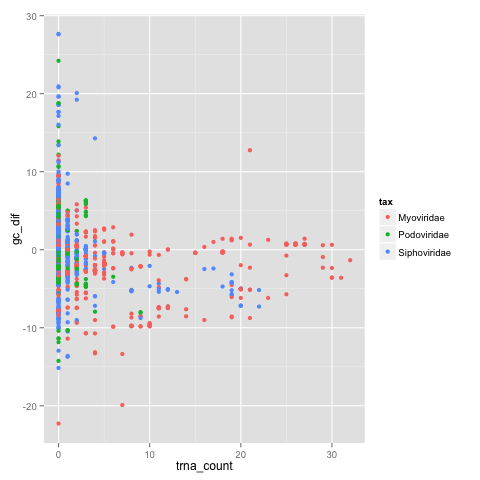

In [170]:
%%R
dots<-ggplot(thi, aes(trna_count, gc_dif))+geom_point(aes(color=tax))
plot(dots)

###Now look at what the tRNAs encode:

In [189]:
%%R
head(t)
t$tax<-p$tax[match(t$phage_full, p$ncbi_acc)]
tcaudos<-t[grepl("Myoviridae|Podoviridae|Siphoviridae",t$tax),]

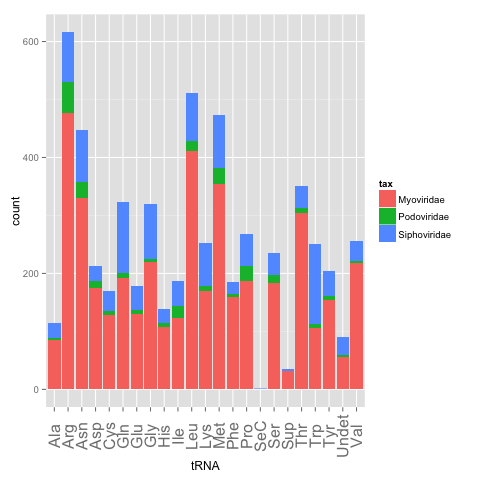

In [197]:
%%R
ggplot(tcaudos,aes(tRNA, fill=tax))+geom_bar()+theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=16))->zeplot
plot(zeplot)

In [178]:
%%R

thi%>%group_by(host, trna_binary)%>%summarise(count=n(), mean_trna=round(mean(trna_count), digits=1))->host_sum
hs_trna<-host_sum[which(host_sum$trna_binary==1),][,c(1,3,4)]
colnames(hs_trna)[2]<-"trna_phage_count"
hs_nt<-host_sum[which(host_sum$trna_binary==0),][,c(1,3)]
hs2<-merge(hs_trna, hs_nt, by="host")
hs2<-mutate(hs2, total_phage=trna_phage_count+count,pct_trna_phage=round((trna_phage_count/(trna_phage_count+count)*100), digits=0))
hs2[,c(1,5,2,3,6)]->hs2
colnames(hs2)<-c("host","total","tRNA_Containing", "mean_#_tRNAs", "percent_tRNA_encoding")
hs2[order(-hs2$percent_tRNA_encoding),]
write.table(hs2, file="phage_trnas_by_host_summary_tbl.txt", sep="\t", quote=FALSE, row.names=FALSE)

In [187]:
%%R
round(mean(thi$trna_count[which(thi$trna_binary==1)]), digits=1)


[1] 5.9
